In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns

## Data Understanding


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/genres_original'

classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [ ]:
import IPython

#sample Audio
audio = '/content/drive/MyDrive/genres_original/hiphop/hiphop.00082.wav'
data, sr = librosa.load(audio)
IPython.display.Audio(data, rate=sr)

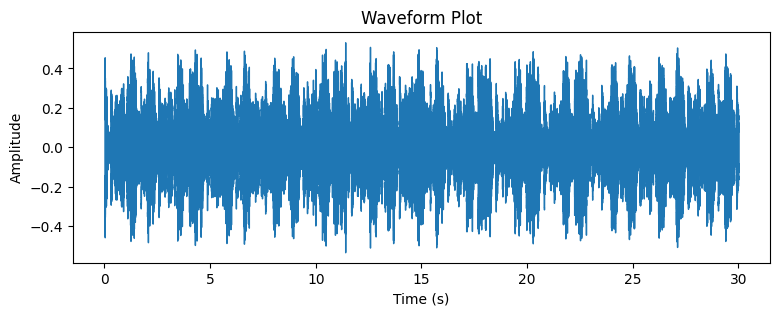

In [ ]:
#plot the audio file

plt.figure(figsize=(9, 3))
librosa.display.waveshow(data, sr=sr)
plt.title('Waveform Plot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

[[4.8898270e+01 6.7254395e+01 1.6885571e+01 ... 5.6066865e-01
  1.7162387e-01 4.4800863e-02]
 [1.3737827e+02 2.0137813e+02 8.3517113e+01 ... 4.1163335e+00
  1.0584116e+00 3.4263946e-02]
 [6.6578674e+01 6.5203796e+01 9.5242599e+01 ... 2.0312397e+00
  7.1766436e-01 9.5528573e-02]
 ...
 [1.4568932e-04 3.6355275e-05 1.1448794e-06 ... 2.7924175e-06
  2.6492487e-06 1.3321097e-05]
 [1.2867201e-04 3.1631414e-05 8.6282547e-08 ... 1.2612279e-07
  3.6106354e-07 1.1279045e-05]
 [1.2156880e-04 2.9905152e-05 1.1867898e-08 ... 9.8335056e-09
  2.0367079e-07 1.0274971e-05]]


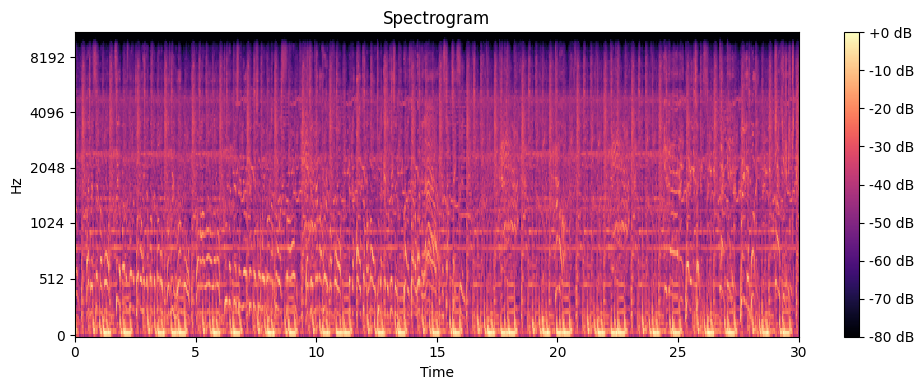

In [ ]:
# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
print(spectrogram)

# Convert to decibels (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
# Visualize the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


## Data Preprocessing


In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                # Define the duration of each chunk and overlap
                chunk_duration = 6  # seconds
                overlap_duration = 3  # seconds

                # Convert durations to samples
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                # Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                # Iterate over each chunk
                for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples

                    # Extract the chunk of audio
                    chunk = audio_data[start:end]

                    # Compute the Mel spectrogram for the chunk
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)

                #mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    data.append(mel_spectrogram)
                    labels.append(i_class)

    return np.array(data), np.array(labels)

In [ ]:
data, labels = load_and_preprocess_data(data_dir, classes)


Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [ ]:
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:

labels.shape

(9980, 10)

In [ ]:
data.shape

(9980, 150, 150, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((7984, 150, 150, 1), (7984, 10))

In [ ]:
X_test.shape, y_test.shape

((1996, 150, 150, 1), (1996, 10))

## Modelling

In [ ]:
model = tf.keras.models.Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(MaxPool2D(pool_size=2,strides=2))


model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))


model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=len(classes),activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,699,594 (14.11 MB)

 Trainable params: 3,699,594 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
training_history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - accuracy: 0.1669 - loss: 3.8627 - val_accuracy: 0.2896 - val_loss: 1.9411
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.3150 - loss: 1.8743 - val_accuracy: 0.4719 - val_loss: 1.5487
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4594 - loss: 1.5731 - val_accuracy: 0.5812 - val_loss: 1.2040
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5369 - loss: 1.3372 - val_accuracy: 0.6042 - val_loss: 1.1963
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6010 - loss: 1.1715 - val_accuracy: 0.6298 - val_loss: 1.0995
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6444 - loss: 1.0598 - val_accuracy: 0.6989 - val_loss: 0.8578
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7151 - loss: 0.8851 - val_accuracy: 0.7285 - val_loss: 0.8402
Epoch 8/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7284 - loss: 0.8142 - 

## Evaluation

In [ ]:
##Model Evaluation on Training set
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.9953657388687134


In [ ]:
##Model Evaluation on Training set
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.914829671382904


In [ ]:
X_test.shape

(1996, 150, 150, 1)

In [ ]:
y_test.shape

(1996, 10)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
y_predicted = model.predict(X_test)
y_pred = []
for i in y_predicted:
  y_pred.append(np.argmax(i))

y_test_list = np.argmax(y_test, axis=1).tolist()

print('\nAccuracy Score',accuracy_score(y_test_list,y_pred)*100,'%')
print('Precision Macro Score ',precision_score(y_test_list,y_pred,average = 'macro')*100,'%')
print('Recall_Score',recall_score(y_test_list,y_pred, average = 'macro')*100,'%')
print('F1_Score',f1_score(y_test_list,y_pred, average = 'macro')*100,'%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Accuracy Score 91.48296593186373 %
Precision Macro Score  91.41549406898322 %
Recall_Score 91.56336456384511 %
F1_Score 91.41181268501735 %


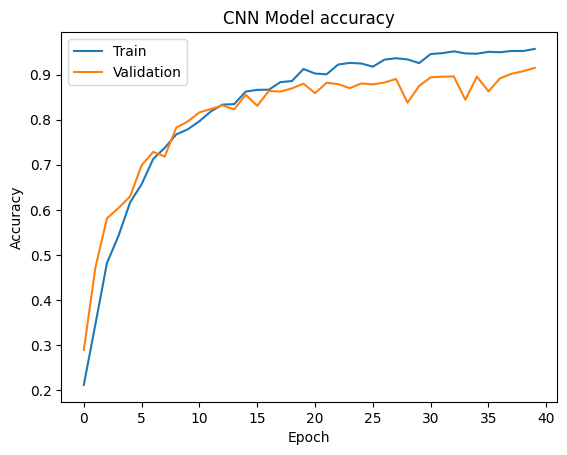

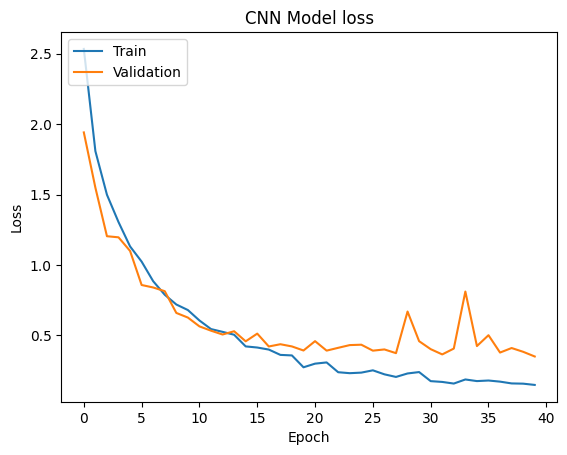

In [ ]:
# Plot training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


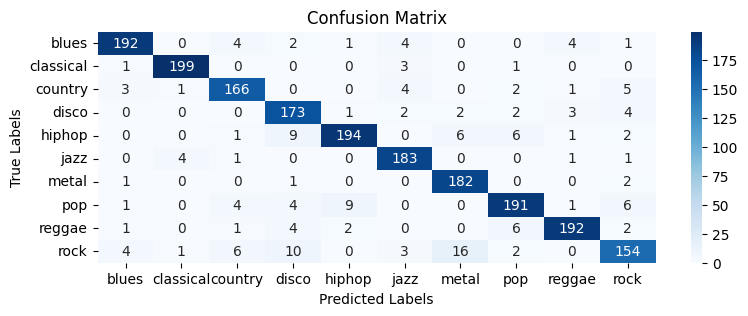

In [ ]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Predict the labels for the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
true_categories = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_categories, y_pred)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Testing Outside Data

In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data(file_path, target_shape=(150, 150)):
    data = []
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
    # Define the duration of each chunk and overlap
    chunk_duration = 6 # seconds
    overlap_duration = 3  # seconds

    # Convert durations to samples
    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate

    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    # Iterate over each chunk
    for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples

                    # Extract the chunk of audio
        chunk = audio_data[start:end]

                    # Compute the Mel spectrogram for the chunk
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)

                #mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        data.append(mel_spectrogram)

    return np.array(data)

In [ ]:
#Processing Test File
file_path = '/content/Eminem - Rap God (Explicit).mp3'
X_test = load_and_preprocess_data(file_path)

In [ ]:
#Model Prediction
def model_prediction(X_test):
    y_pred = model.predict(X_test)
    predicted_categories = np.argmax(y_pred,axis=1)
    unique_elements, counts = np.unique(predicted_categories, return_counts=True)
    #print(unique_elements, counts)
    max_count = np.max(counts)
    max_elements = unique_elements[counts == max_count]
    return max_elements[0]

In [ ]:
#Model Prediction
c_index = model_prediction(X_test)
print(f"Model Prediction :: Music Genre --> {classes[c_index]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Model Prediction :: Music Genre --> hiphop


In [ ]:
saved_model  = model.save('/content/drive/MyDrive/Music_Dataset/Data/cnn_model.h5')